In [10]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [2]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


Features and Label

In [3]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Train/test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Features selection with backword stepwise elimination (with multinominal logistische regression)

In [ ]:
#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

X_BSE_list = multinomial(X)
X_BSE_list.remove('const')
X_postBSE = X[X_BSE_list]


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


Feature selection with SelectKBest and find best k

In [8]:
# === initialize dataframe for readout ===
kbest_df = pd.DataFrame({"Selected Feature": [],
            "Accuracy" : [],
            'Precision': [],
            'Recall':    [],
            'F1 Score':  []})
# === Feature selection with selectKbest ===
for i in range(1,22):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    selector = SelectKBest(score_func=mutual_info_classif,k=i)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # === Random forest with balanced class weights ===
    rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
    rdf.fit(X_train_selected, y_train)
    y_pred = rdf.predict(X_test_selected)

    # === Evaluate ===
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    #kbest_df.loc[i, "Selected Feature"] = str(selected_features)
    kbest_df.loc[i, "Accuracy"] = accuracy
    kbest_df.loc[i, 'Precision'] = precision
    kbest_df.loc[i, 'Recall'] = recall
    kbest_df.loc[i, 'F1 Score'] = f1
kbest_df

/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Selected Feature,Accuracy,Precision,Recall,F1 Score
1,NaN,0.634244,0.390131,0.459072,0.372282
2,NaN,0.606216,0.423613,0.483322,0.398417
3,NaN,0.600166,0.426464,0.490142,0.398235
4,NaN,0.625374,0.425982,0.484142,0.404456
5,NaN,0.622832,0.425178,0.478705,0.402403
6,NaN,0.643074,0.421939,0.471043,0.404892
7,NaN,0.661660,0.419254,0.460955,0.407241
8,NaN,0.674137,0.414650,0.449569,0.405889
9,NaN,0.725106,0.407235,0.420206,0.405156
10,NaN,0.775978,0.407317,0.397415,0.400682


Features selection togheter with hyperparametertuning

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  12.1s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  12.7s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  12.7s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  12.4s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  12.9s
[CV] END feature_s

/Users/miniconda3/envs/fods/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END feature_selection__k=20, rf__bootstrap=False, rf__max_depth=None, rf__max_features=0.5, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=200; total time= 1.4min
[CV] END feature_selection__k=11, rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=50; total time=  19.5s
[CV] END feature_selection__k=20, rf__bootstrap=False, rf__max_depth=None, rf__max_features=0.5, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=200; total time= 1.4min
[CV] END feature_selection__k=20, rf__bootstrap=False, rf__max_depth=None, rf__max_features=0.5, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=200; total time= 1.4min
[CV] END feature_selection__k=6, rf__bootstrap=False, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  23.6s
[CV] END feature_selection__k=6, rf__bootstrap=False, rf__max_dep

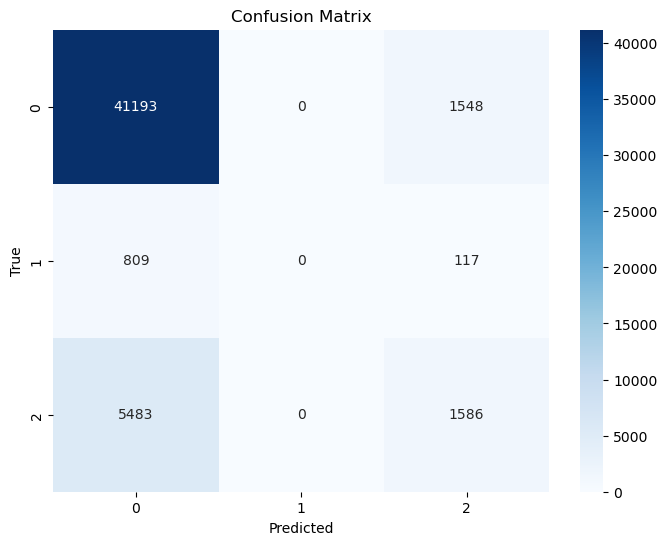

Best parameters from tuning: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': None, 'rf__bootstrap': False, 'feature_selection__k': 20}
Best CV score (macro F1): 0.4046226690324093
Accuracy: 0.8431685588142542
Precision (macro): 0.4517816302537907
Recall (macro): 0.39604724332719576
F1 Score (macro): 0.40682380924478423

Classification Report:

              precision    recall  f1-score   support

           0     0.8675    0.9638    0.9131     42741
           1     0.0000    0.0000    0.0000       926
           2     0.4878    0.2244    0.3074      7069

    accuracy                         0.8432     50736
   macro avg     0.4518    0.3960    0.4068     50736
weighted avg     0.7988    0.8432    0.8120     50736



/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [12]:
# === Pipeline definition ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

# === Combined hyperparameter grid ===
param_dist = {
    'feature_selection__k': list(range(1, X_train.shape[1] + 1)),  # test all k from 1 to total features
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False]
}

# === Cross-validated randomized search ===
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# === Fit search on full training set ===
random_search.fit(X_train, y_train)

# === Evaluate on hold-out test set ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === Metrics ===
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score (macro F1):", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Random forest feature selection

Top Random Forest Features: ['BMI' 'Age' 'Income' 'PhysHlth' 'Education' 'GenHlth']


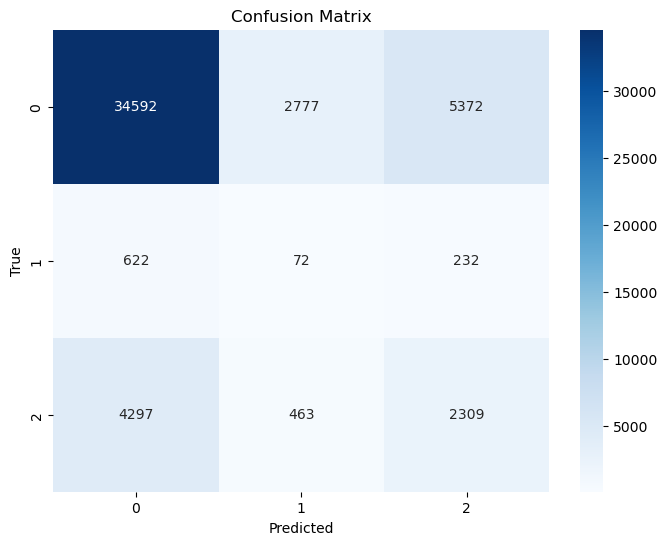

Random Forest Classifier
Accuracy: 0.7287330495111952
Precision: 0.39634682049769393
Recall: 0.4045770629138706
F1 Score: 0.39444574883091293
Log Loss: 1.2424020885623102
Cohen Kappa Score: 0.15503249876643


In [23]:
# Train a Random Forest to get feature importances
temp_rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
temp_rdf.fit(X, y)

# Get feature importances
importances = temp_rdf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top k important features
k=6
top_features = importance_df['Feature'].head(k).values
print("Top Random Forest Features:", top_features)

# Use only the selected features
X_selected_rf = pd.DataFrame(X, columns=X.columns)[top_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

# Train final model
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
rdf.fit(X_train, y_train)

# Predict
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

In [17]:
"""
#  ==== Scaling ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==== Feature selection ====
selector = SelectKBest(score_func=f_classif, k=9)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=data.index)
"""
# ==== Train-test split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Pipeline ====
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False],
    'rf__class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  54.8s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  56.4s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  56.6s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  48.1s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_spl

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time= 1.6min
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time= 1.6min
[CV] END rf__bootstrap=

KeyboardInterrupt: 

SMOTE + RF. Let's see

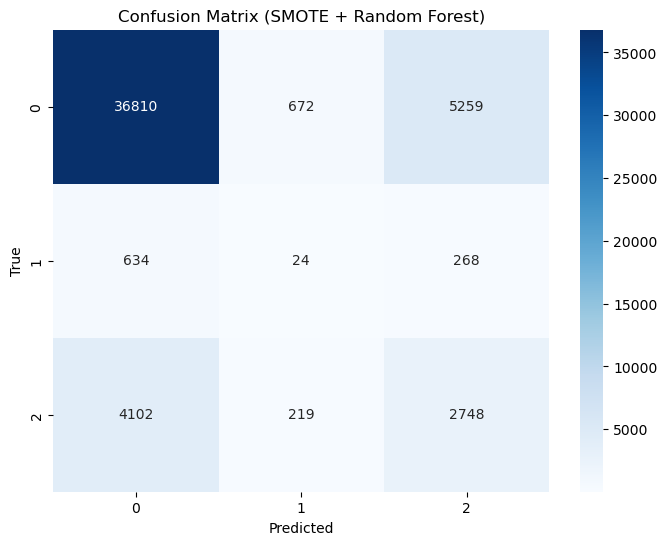

Random Forest Classifier with SMOTE
Accuracy: 0.7801561021759698
Precision (macro): 0.41477332444998943
Recall (macro): 0.4252971458927152
F1 Score (macro): 0.41923423331049
Log Loss: 1.4077177184555372
Cohen Kappa Score: 0.23430657440459035

Classification Report:

              precision    recall  f1-score   support

           0     0.8860    0.8612    0.8734     42741
           1     0.0262    0.0259    0.0261       926
           2     0.3321    0.3887    0.3582      7069

    accuracy                         0.7802     50736
   macro avg     0.4148    0.4253    0.4192     50736
weighted avg     0.7931    0.7802    0.7862     50736



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline con SMOTE + Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SMOTE + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with SMOTE")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))